In [25]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from typing import Literal
from langchain_core.documents.base import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import  ChatOpenAI

from langchain_core.output_parsers import StrOutputParser
import importlib
import sys
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

In [2]:
sys.path.append("../src/")
from utils import get_retriever, get_llm

**State**

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    documents: list[Document]

**Edges**

In [12]:
def grade_answer(state):
    messages = state['messages']
    question = messages[-2]
    answer = messages[-1]

    class GradeAnswer(BaseModel):
        binary_score: Literal["yes", "no"] = Field(description="Answer addresses the question, 'yes' or 'no'")

    system = """You are a grader assessing whether an answer addresses / resolves a question about Thai laws.\n
    If the answer resolves the question, answer 'yes'. Otherwise, answer 'no'.
    """
    grading_prompt = ChatPromptTemplate.from_messages(
        [("system", system),
         ("human", "User question:\n\n{question}\n\nAnswer: {generation}")]
    )
    llm = get_llm().with_structured_output(GradeAnswer)
    chain = grading_prompt | llm


    score = chain.invoke({
        "question": question,
        "generation": answer
    }).binary_score

    return score

**Nodes**

In [13]:
def transform_query(state):
    llm = get_llm()
    question = state['messages'][0]

    system = """You are a Thai legal question rewriter that converts an input to a better version that is optimized\n
    for Thai legal code retrieval. Look at the question and reason about the underlying semantic intent / meaning."""
    rewriting_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Initial question\n\n{question}\n\nFormulate an improved one: ")
    ])

    chain = rewriting_prompt | llm | StrOutputParser()
    res = chain.invoke({"question": question})

    return {
        "messages": [res],
        "documents": state['documents']
    }

In [14]:
def generate(state):
    question = state['messages'][-1]
    documents = state['documents']

    llm = get_llm()
    template = """You are an assistant for question-answering tasks about Thai laws.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know. Keep the answer concise but comprehensive.
    If it is a procedural question, structure the answer as a numbered list.
    Keep a friendly, semi-formal tone, refer to yourself as 'ทนายแตน' and use คะ/ค่ะ when neccessary. 
    \nQuestion: {question}
    \nContext: {context} 
    \nAnswer:"""

    prompt = ChatPromptTemplate.from_template(
        template=template,
        input_variable=['context', 'question']
    )

    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    chain = prompt | llm | StrOutputParser()
    generation = chain.invoke({
        "context": formatted_docs,
        "question": question
    })

    return {
        "documents": state['documents'],
        "messages": [generation]
    }
    
    

In [32]:
def similarity_search(state):
   retriever = get_retriever("CCC", from_notebooks=True) # TODO: remove this after testing
   question = state['messages'][-1].content

   return {"documents": retriever.invoke(question, k=3)}

In [29]:
workflow = StateGraph(State)

workflow.add_node("similarity_search", similarity_search)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)



workflow.add_edge(START,
                  "similarity_search")
workflow.add_edge("similarity_search",
                  "generate")



workflow.add_conditional_edges("generate",
                               grade_answer,
                               {
                                   "yes": END,
                                   "no": "transform_query"
                               }
                              )

workflow.add_edge("transform_query", "similarity_search")
app = workflow.compile()

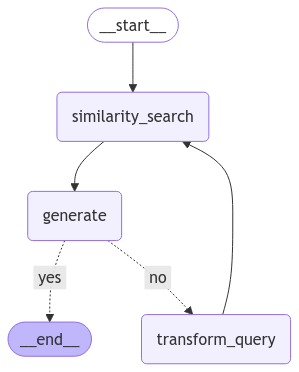

In [30]:
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass